This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib
import shutil
import subprocess  # subprocess handling
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
from cellpose import core
from cellpose import io as cellpose_io
from cellpose import models

cellpose_io.logger_setup()
import torch
from cellpose.io import imread
from PIL import Image
from skimage import io

use_GPU = torch.cuda.is_available()

# set import path
sys.path.append(str(pathlib.Path("../../utils/").resolve()))

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

2025-01-09 12:58:08,843 [INFO] WRITING LOG OUTPUT TO /home/lippincm/.cellpose/run.log
2025-01-09 12:58:08,844 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.9.21 
torch version:  	2.5.1+cu124
True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--window_size", type=int, help="Size of the window to use for the segmentation"
    )
    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    window_size = args.window_size
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)

else:
    input_dir = pathlib.Path("../../data/z-stack_images/G8-1/").resolve(strict=True)
    window_size = 3
    clip_limit = 0.1

mask_path = pathlib.Path(f"../processed_data/{input_dir.stem}").resolve()
mask_path.mkdir(exist_ok=True, parents=True)

## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [4]:
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        nuclei = io.imread(f)
    elif "488" in f:
        cyto1 = io.imread(f)
    elif "555" in f:
        cyto2 = io.imread(f)
    elif "640" in f:
        cyto3 = io.imread(f)
    elif "TRANS" in f:
        brightfield = io.imread(f)
    else:
        print(f"Unknown channel: {f}")

cyto = np.max([cyto1, cyto2, cyto3], axis=0)
# pick which channels to use for cellpose
cyto = skimage.exposure.equalize_adapthist(cyto1, clip_limit=clip_limit)


original_cyto_image = cyto.copy()

original_cyto_z_count = cyto.shape[0]

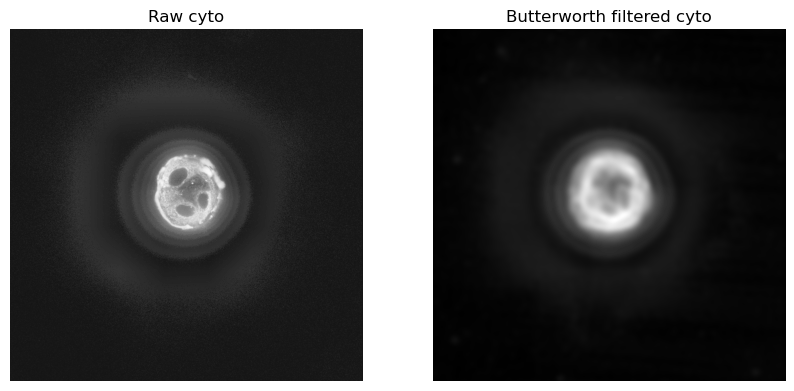

In [5]:
# # make a 2.5 D max projection image stack with a sliding window of 3 slices
# image_stack_2_5D = np.empty((0, cyto.shape[1], cyto.shape[2]), dtype=cyto.dtype)
# for image_index in range(cyto.shape[0]):
#     image_stack_window = cyto[image_index : image_index + window_size]
#     if not image_stack_window.shape[0] == window_size:
#         break
#     # guassian blur the image stack
#     image_stack_window = skimage.filters.gaussian(image_stack_window, sigma=1)
#     # max project the image stack
#     image_stack_2_5D = np.append(
#         image_stack_2_5D, np.max(image_stack_window, axis=0)[np.newaxis, :, :], axis=0
#     )

# image_stack_2_5D = np.array(image_stack_2_5D)
# cyto = np.array(image_stack_2_5D)
# print("2.5D cyto image stack shape:", cyto.shape)


# Use butterworth FFT filter to remove high frequency noise :)
imgs = skimage.filters.butterworth(
    cyto,
    cutoff_frequency_ratio=0.025,
    high_pass=False,
    order=5.0,
    squared_butterworth=True,
)
if in_notebook:
    # plot the nuclei and the cyto channels
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(cyto[9, :, :], cmap="gray")
    plt.title("Raw cyto")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(imgs[9, :, :], cmap="gray")
    plt.title(f"Butterworth filtered cyto")
    plt.axis("off")
    plt.show()

In [6]:
# if in_notebook:
#     # plot the nuclei and the cyto channels
#     plt.figure(figsize=(10, 10))
#     plt.subplot(121)
#     plt.imshow(cyto[9, :, :], cmap="gray")
#     plt.title("Raw cyto")
#     plt.axis("off")
#     plt.subplot(122)
#     plt.imshow(imgs[9, :, :], cmap="gray")
#     plt.title(f"Gaussian blur: sigma {sigma}")
#     plt.axis("off")
#     plt.show()

In [7]:
use_GPU = torch.cuda.is_available()
# Load the model
model_name = "cyto3"
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

# Perform segmentation
labels, details, _ = model.eval(
    imgs,
    channels=[0, 0],
    z_axis=0,
    stitch_threshold=0.8,
    diameter=750,
)

2025-01-09 12:58:24,340 [INFO] >> cyto3 << model set to be used
2025-01-09 12:58:24,496 [INFO] ** TORCH CUDA version installed and working. **
2025-01-09 12:58:24,497 [INFO] >>>> using GPU (CUDA)
2025-01-09 12:58:24,538 [INFO] >>>> loading model /home/lippincm/.cellpose/models/cyto3
2025-01-09 12:58:24,579 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-01-09 12:58:24,580 [INFO] multi-stack tiff read in as having 41 planes 1 channels


/home/lippincm/miniforge3/envs/GFF_segmentation/lib/python3.9/site-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

2025-01-09 12:58:25,356 [INFO] 100%|##########| 6/6 [00:00<00:00, 20.69it/s]
2025-01-09 12:58:25,977 [INFO] network run in 0.91s
2025-01-09 12:59:06,124 [INFO] 100%|##########| 41/41 [00:40<00:00,  1.02it/s]
2025-01-09 12:59:06,125 [INFO] stitching 41 planes using stitch_threshold=0.800 to make 3D masks


100%|██████████| 40/40 [00:00<00:00, 49.97it/s]


2025-01-09 12:59:07,303 [INFO] masks created in 41.33s


In [8]:
# reverse sliding window max projection
full_mask_z_stack = []
reconstruction_dict = {index: [] for index in range(original_cyto_z_count)}
print(f"Decoupling the sliding window max projection of {window_size} slices")

# decouple the sliding window max projection based on window size
# each slice in a stack
for z_stack_mask_index in range(len(labels)):
    # temoporary list to hold the decoupled z stack
    z_stack_decouple = []
    # decouple
    [z_stack_decouple.append(labels[z_stack_mask_index]) for _ in range(window_size)]
    # dull out the decouple slice to the correct z index
    for z_window_index, z_stack_mask in enumerate(z_stack_decouple):
        if not (z_stack_mask_index + z_window_index) >= original_cyto_z_count:
            reconstruction_dict[z_stack_mask_index + z_window_index].append(
                z_stack_mask
            )
# for each z stack index, reconstruct the mask
for z_stack_index in range(original_cyto_z_count):
    mask = np.max(reconstruction_dict[z_stack_index], axis=0)
    full_mask_z_stack.append(mask)

full_mask_z_stack = np.array(full_mask_z_stack)

# save the reconstructed image stack to a tiff file
tifffile.imsave(mask_path / "organoid_mask.tiff", full_mask_z_stack)

Decoupling the sliding window max projection of 3 slices


/tmp/ipykernel_3708729/2212025185.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(


<Figure size 1000x500 with 0 Axes>

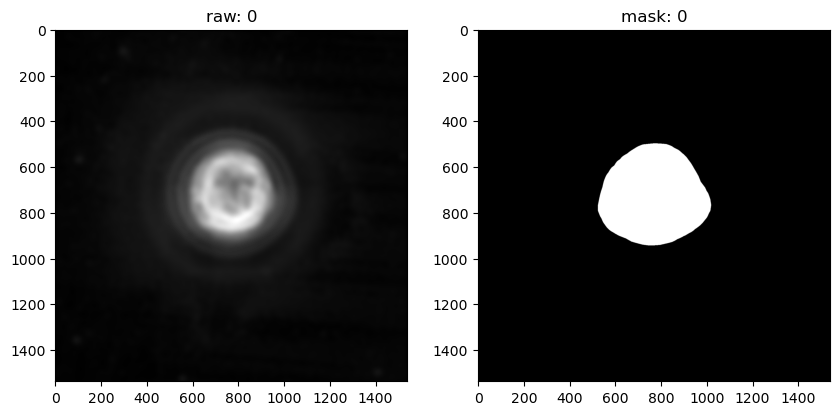

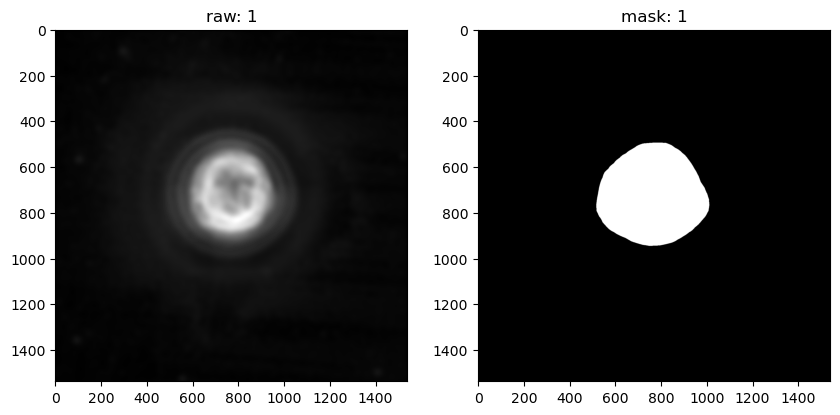

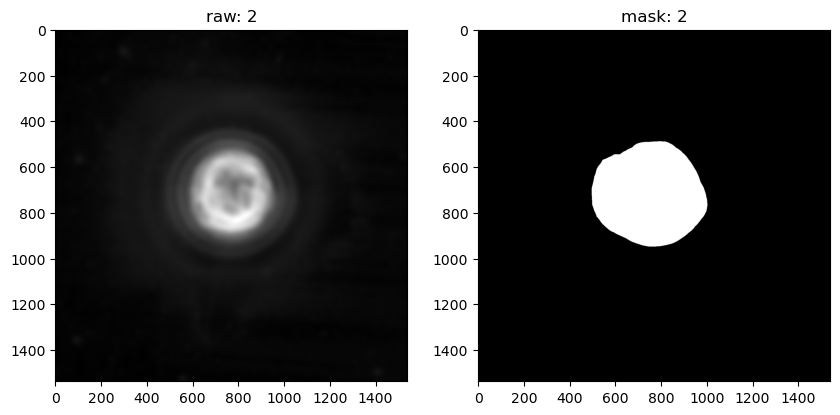

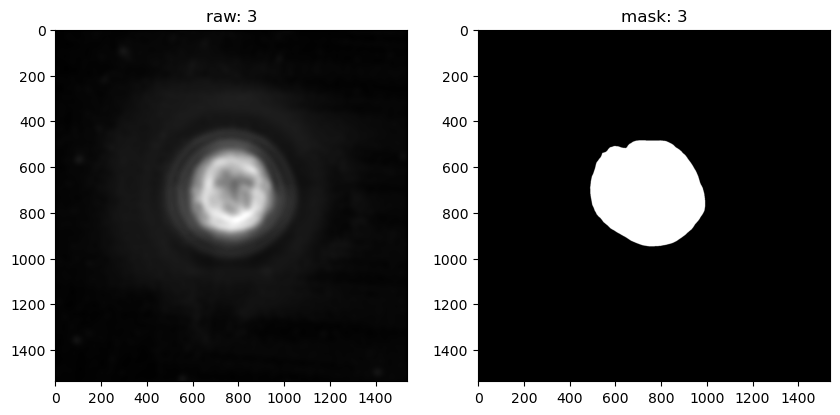

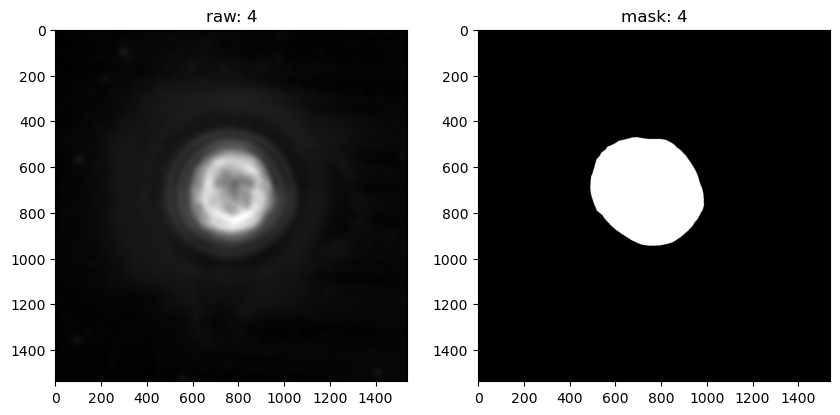

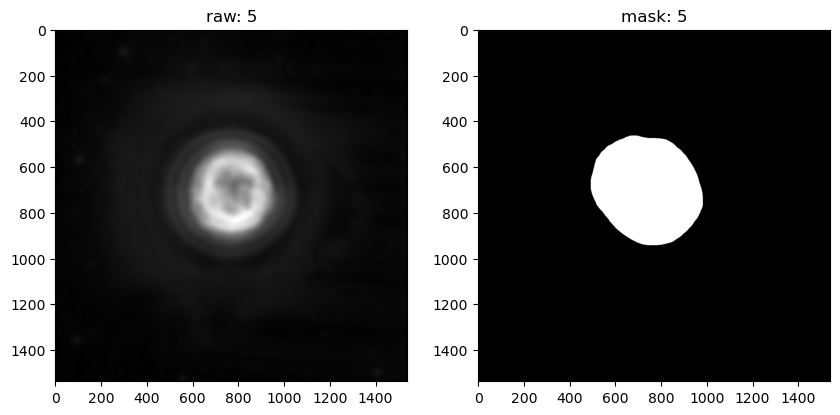

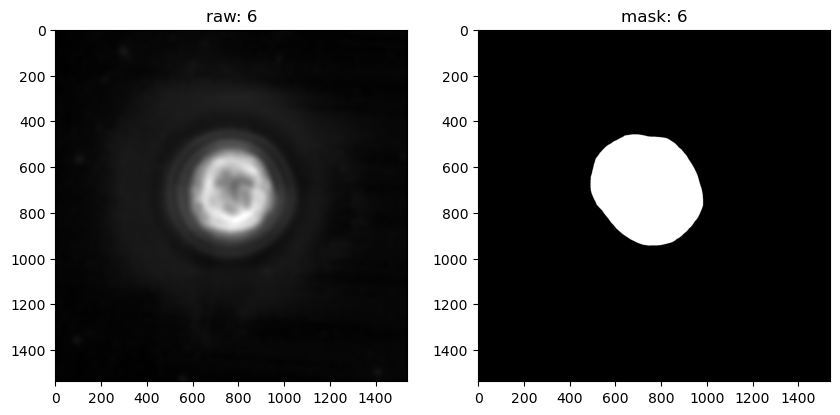

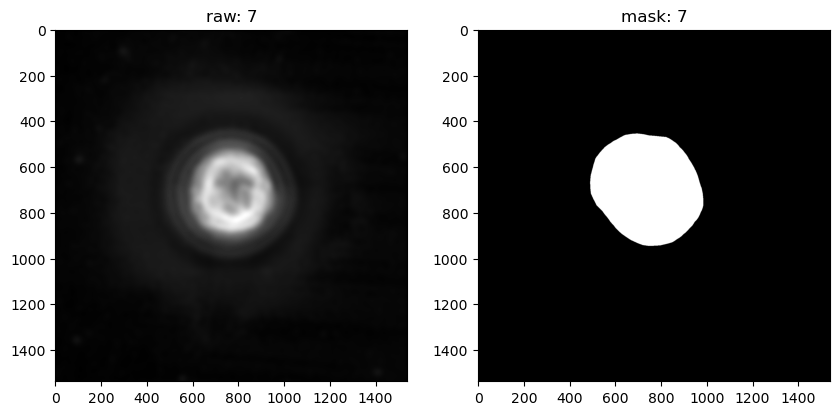

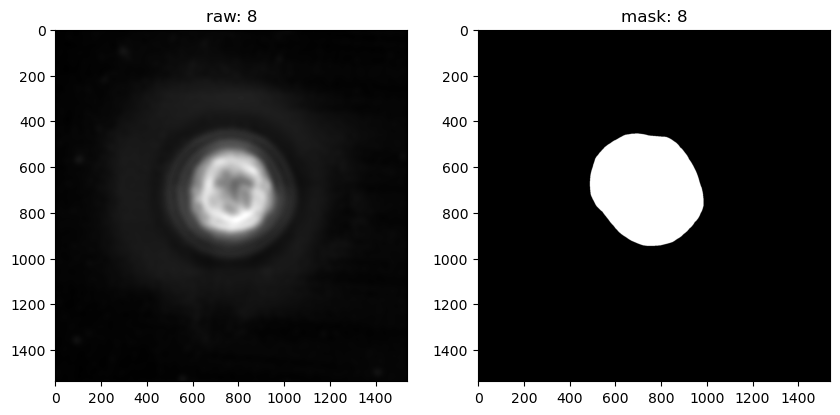

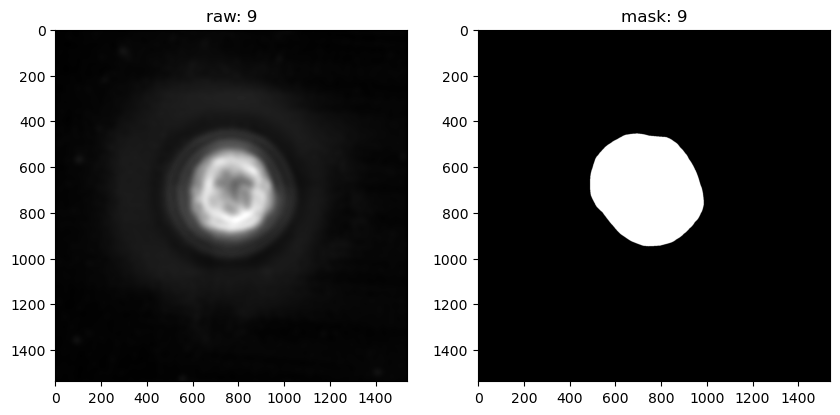

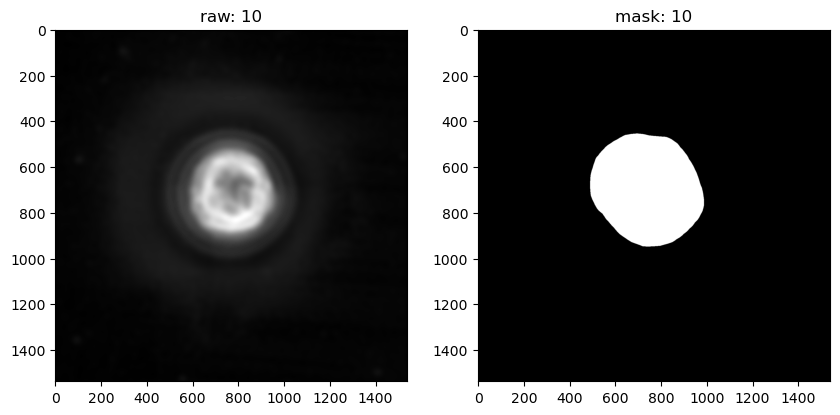

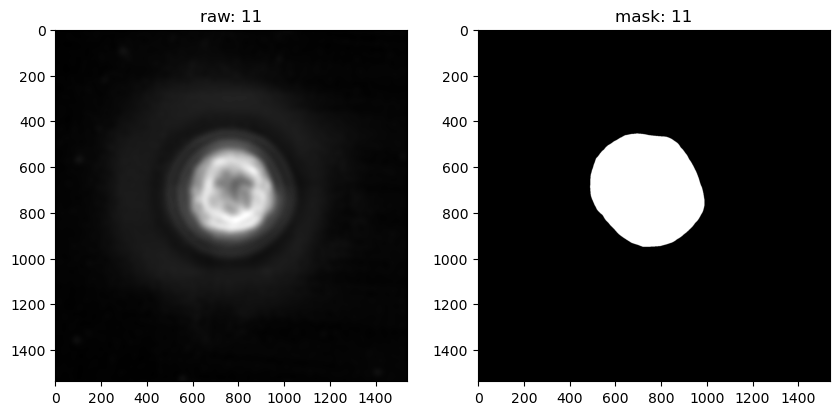

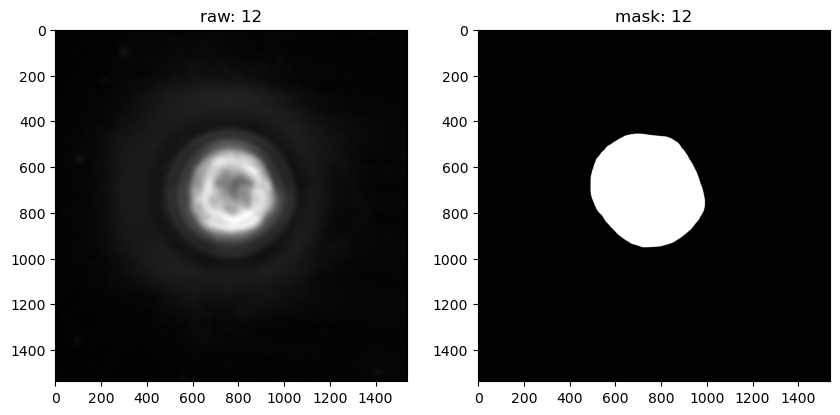

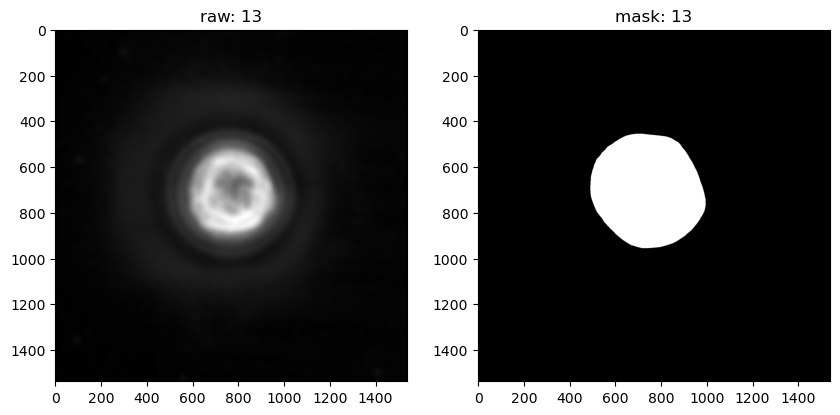

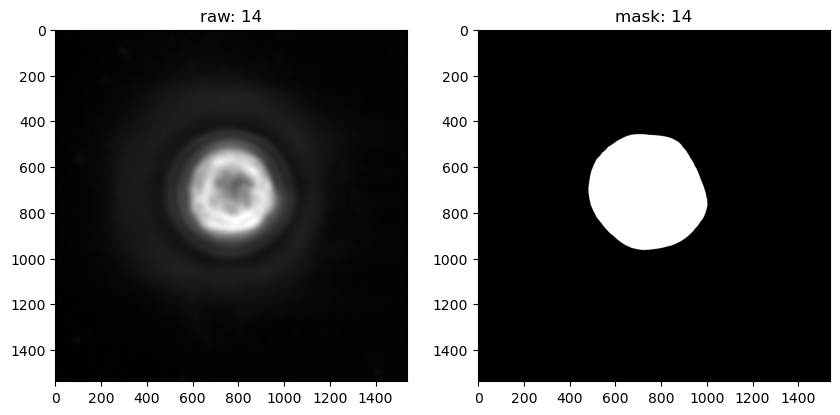

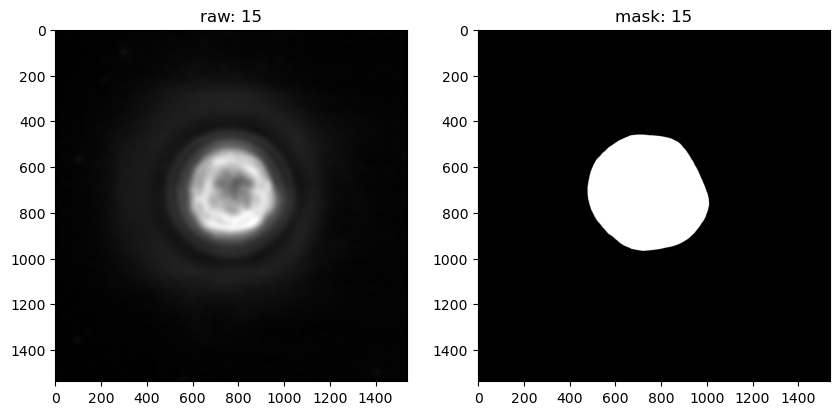

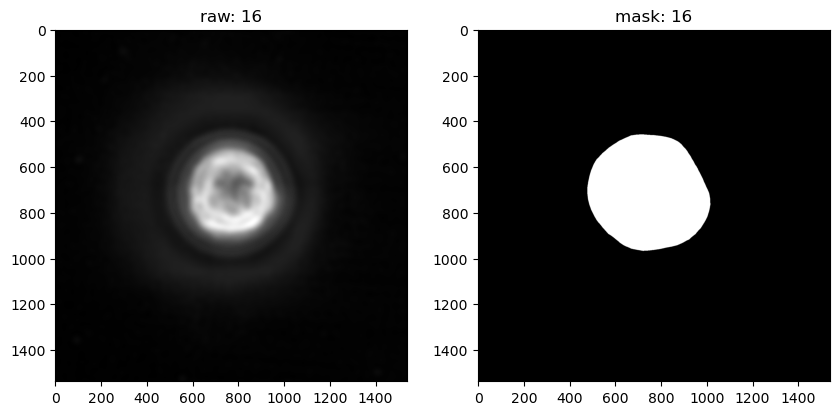

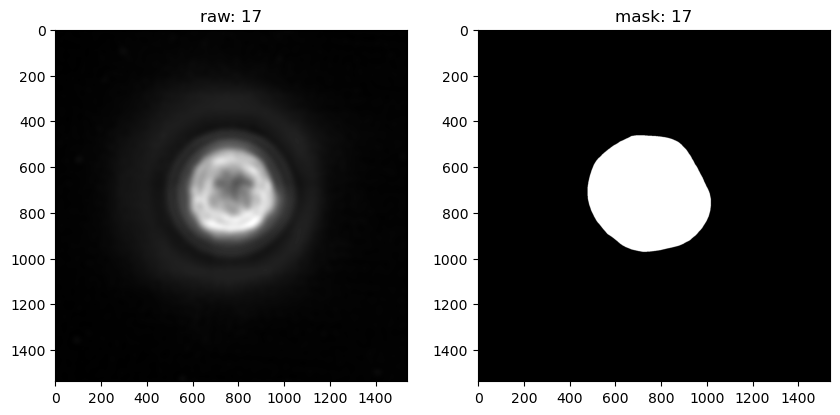

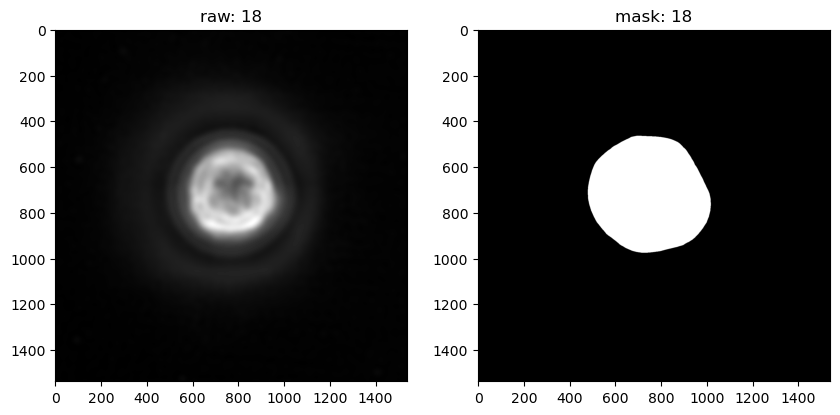

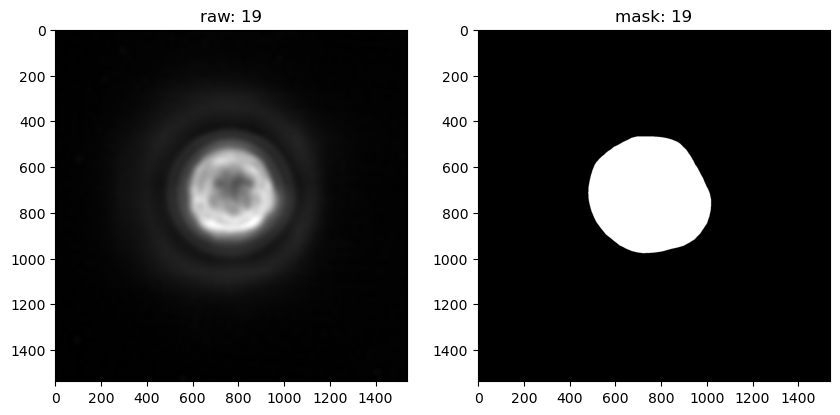

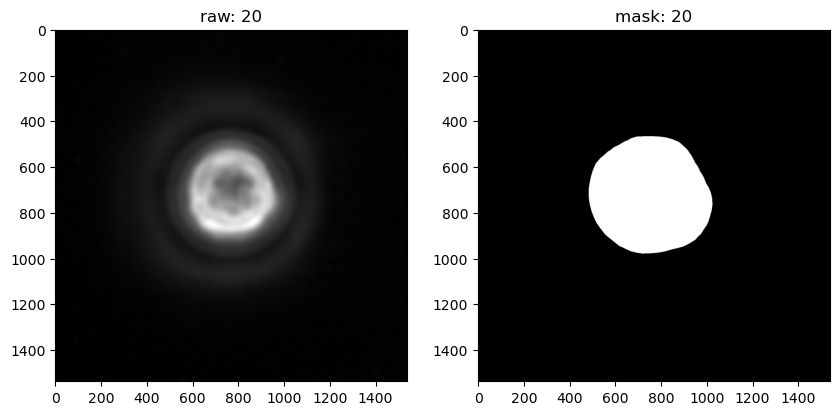

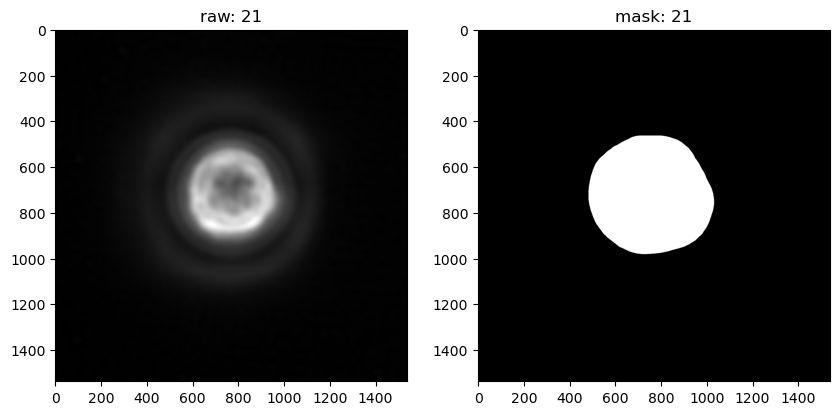

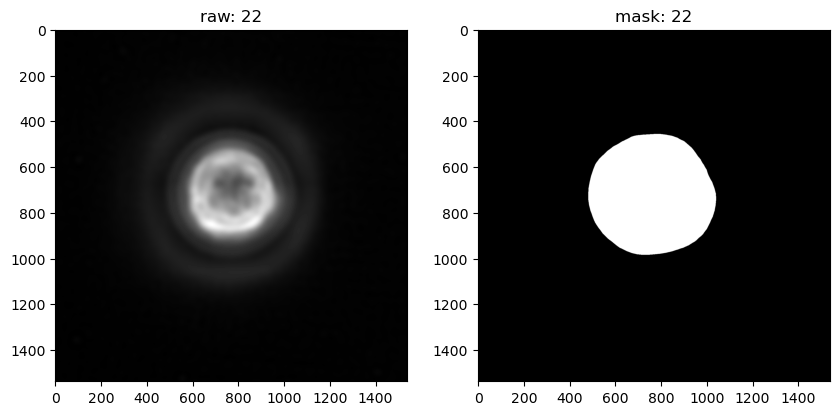

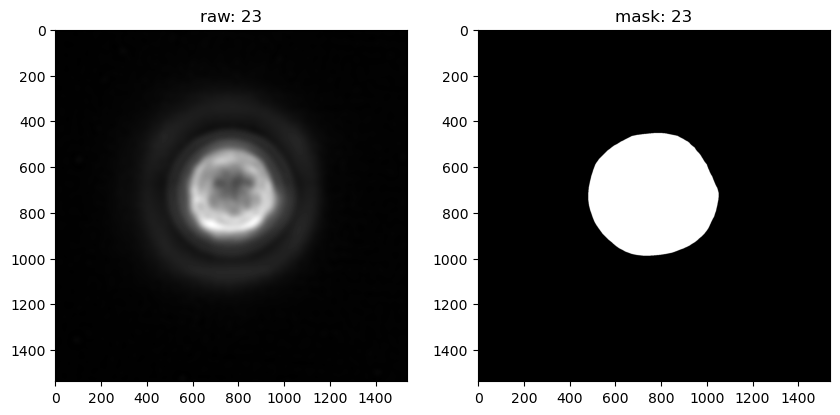

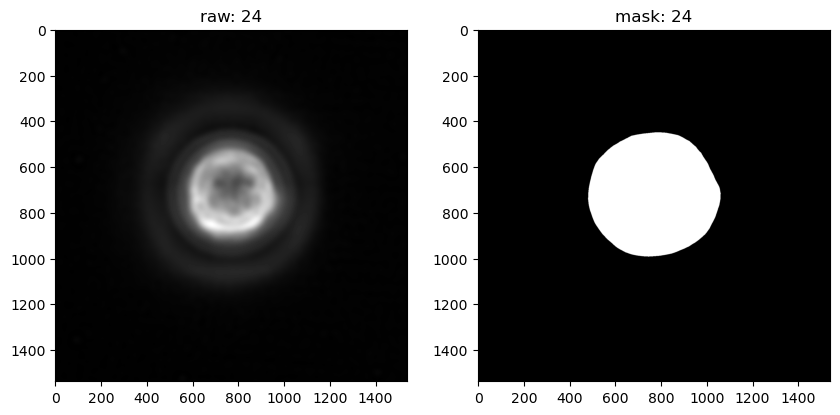

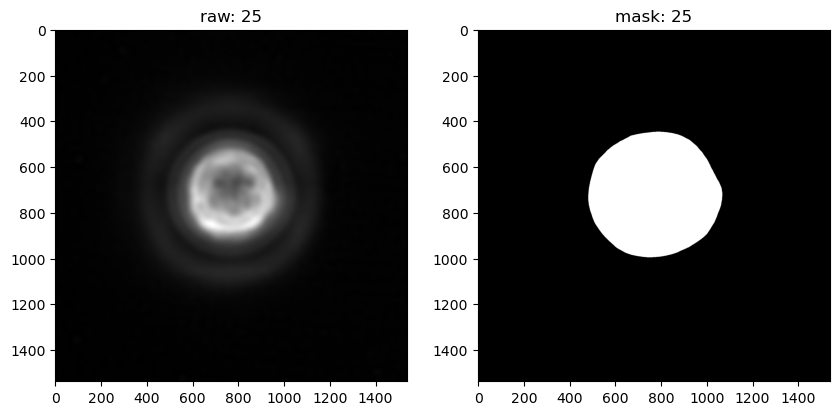

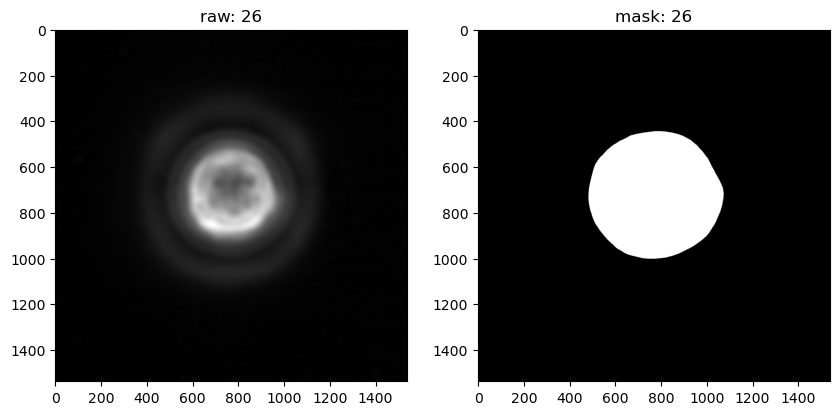

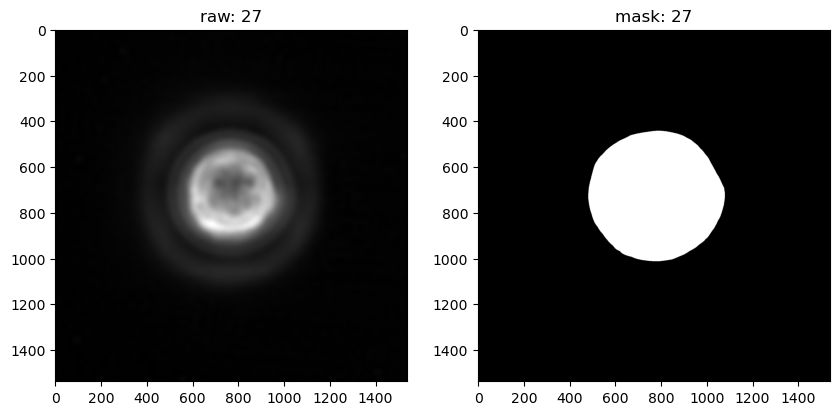

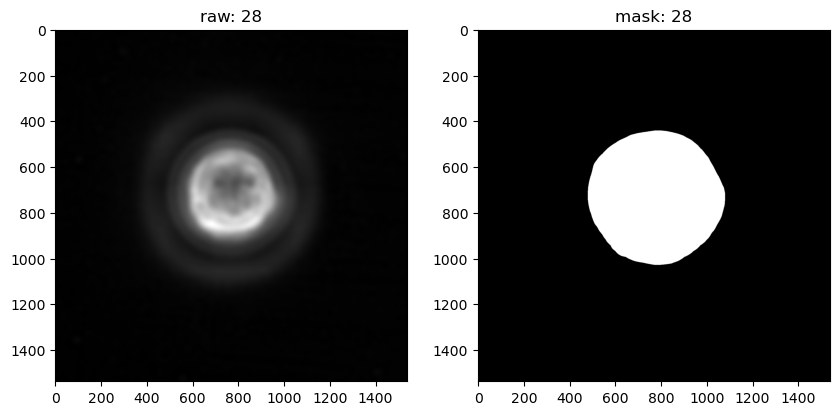

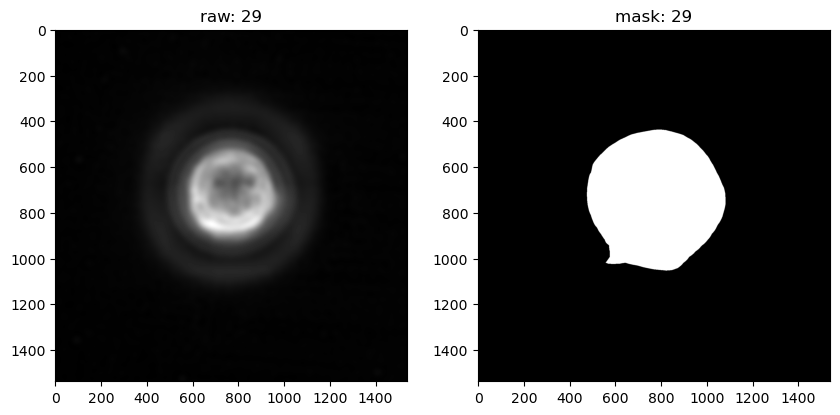

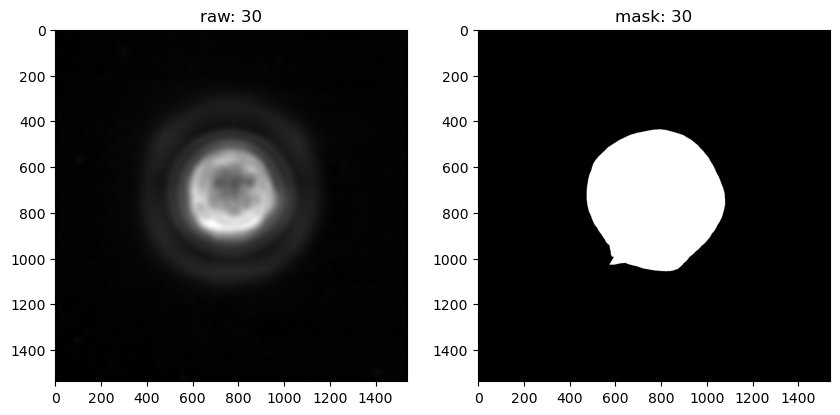

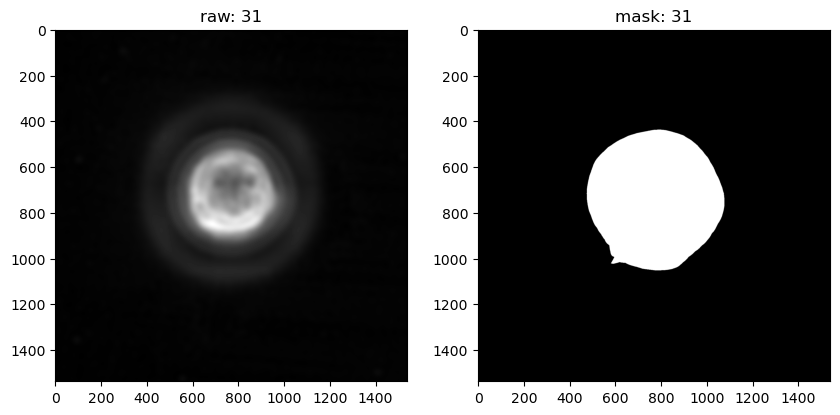

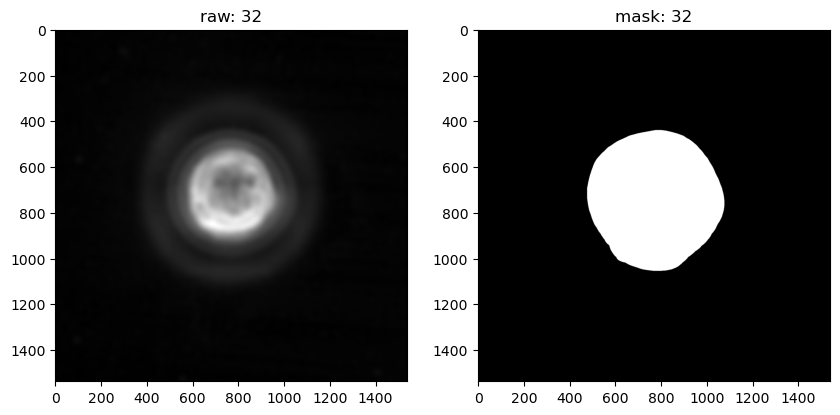

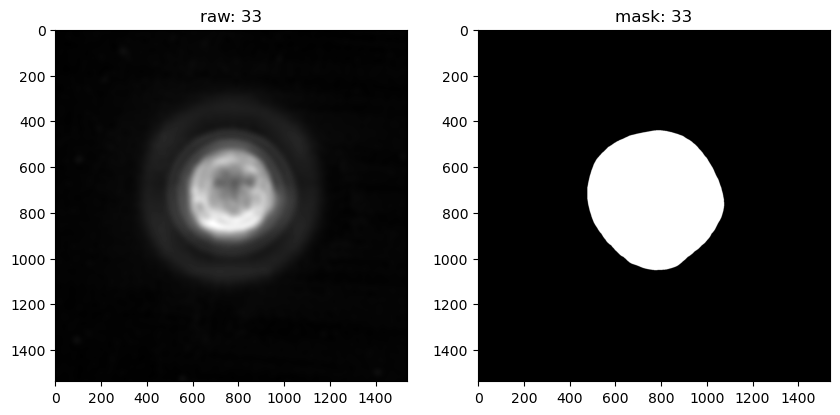

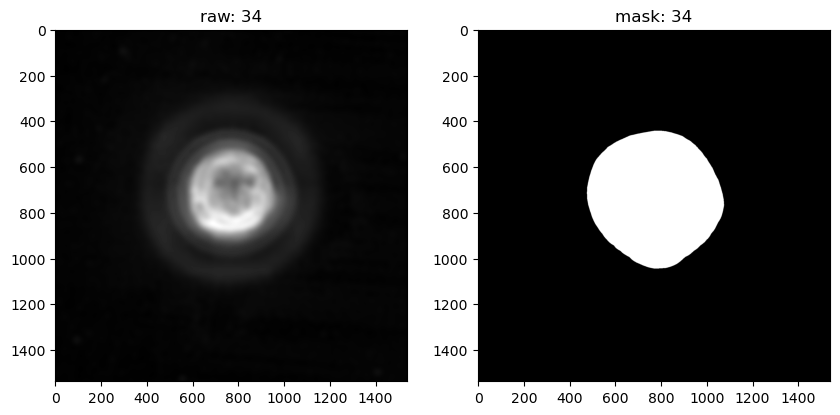

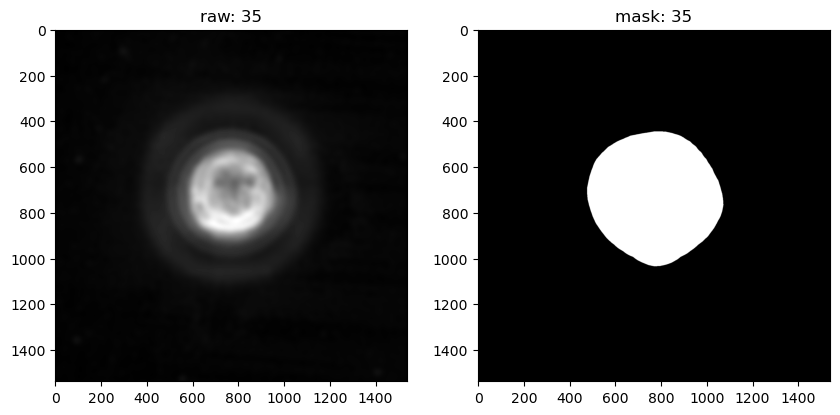

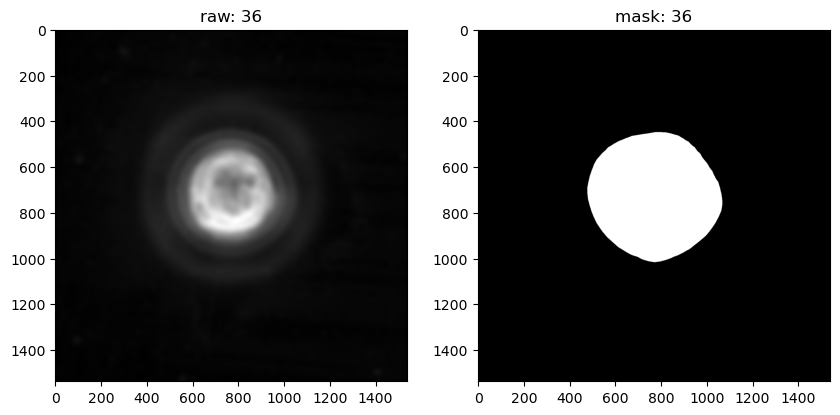

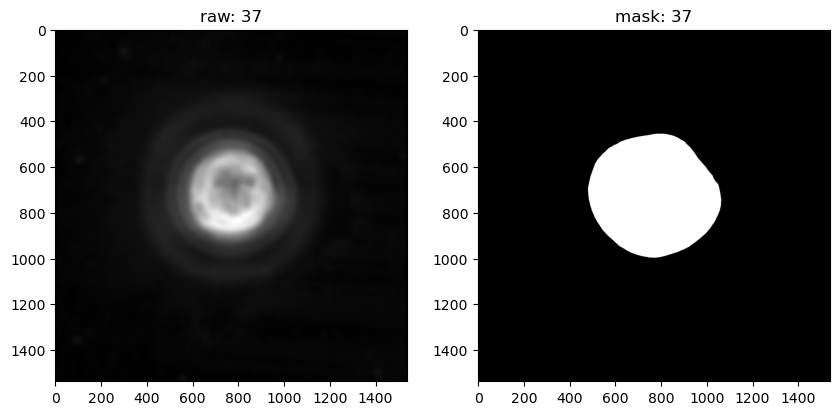

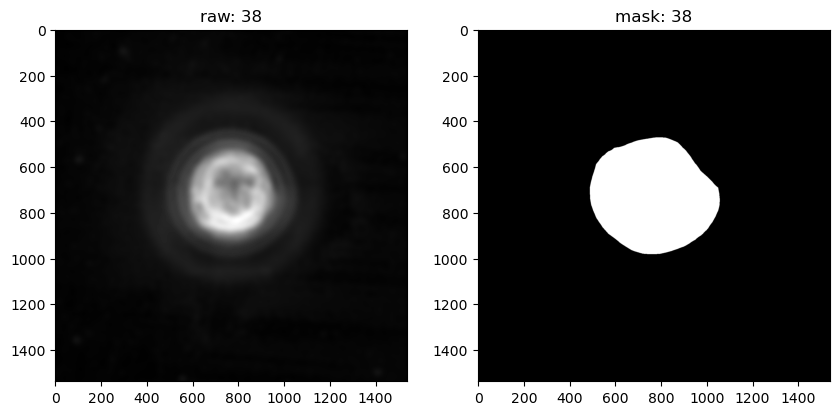

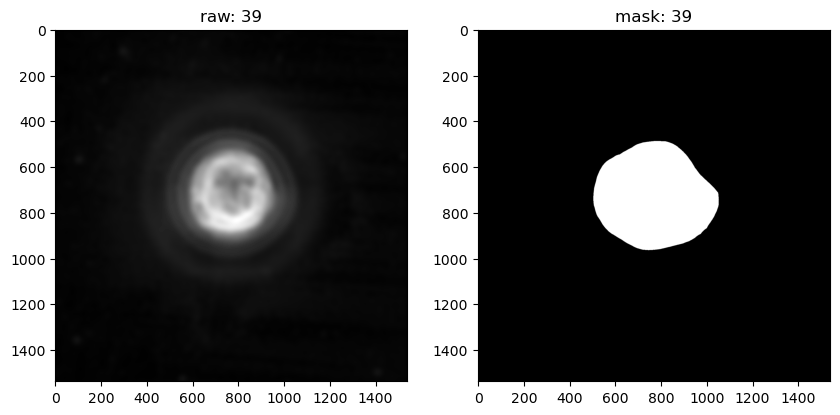

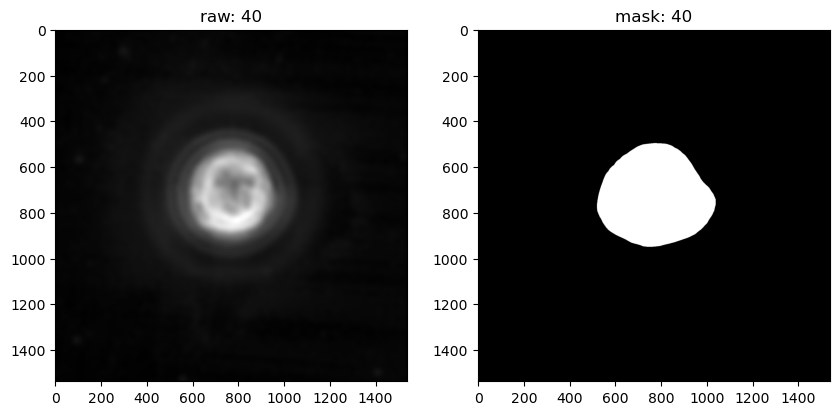

In [9]:
if in_notebook:
    # masks, flows, styles, diams
    plot = plt.figure(figsize=(10, 5))
    for z in range(len(labels)):
        plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(imgs[z], cmap="gray")
        plt.title(f"raw: {z}")
        plt.subplot(122)
        plt.imshow(labels[z], cmap="gray")
        plt.title(f"mask: {z}")
        plt.show()